In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [10]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [11]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
#X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(7352, 4, 32, 9) (2947, 4, 32, 9)


In [12]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [13]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [14]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               4

In [15]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 16s 19ms/step - loss: 0.7705 - accuracy: 0.6708 - val_loss: 0.4262 - val_accuracy: 0.8359
Epoch 2/10
58/58 [==============================] - 0s 7ms/step - loss: 0.3509 - accuracy: 0.8643 - val_loss: 0.2619 - val_accuracy: 0.9012
Epoch 3/10
58/58 [==============================] - 0s 8ms/step - loss: 0.2271 - accuracy: 0.9153 - val_loss: 0.1738 - val_accuracy: 0.9361
Epoch 4/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1675 - accuracy: 0.9334 - val_loss: 0.1342 - val_accuracy: 0.9506
Epoch 5/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1408 - accuracy: 0.9453 - val_loss: 0.1216 - val_accuracy: 0.9492
Epoch 6/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1286 - accuracy: 0.9478 - val_loss: 0.1182 - val_accuracy: 0.9547
Epoch 7/10
58/58 [==============================] - 1s 9ms/step - loss: 0.1163 - accuracy: 0.9505 - val_loss: 0.1241 - val_accuracy: 0.9529
Epoch 8/10
58/58 [

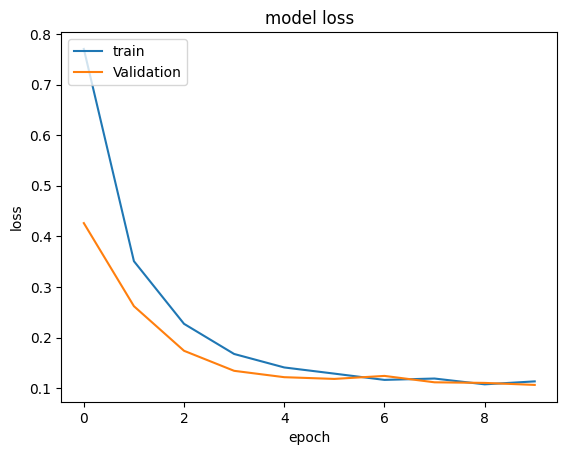

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

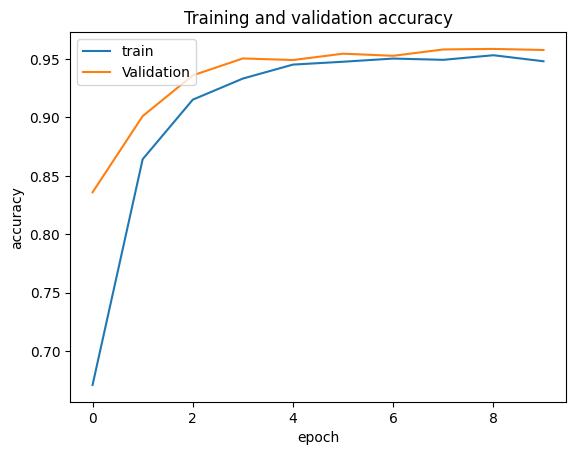

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 3ms/step
[[469   5  22   0   0   0]
 [  5 441  25   0   0   0]
 [  5   2 413   0   0   0]
 [  0  24   0 395  72   0]
 [  0   1   0  93 438   0]
 [  0  27   0   0   0 510]]
0.9046487953851374
0.9045957356212575
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.88      0.94      0.91       471
           2       0.90      0.98      0.94       420
           3       0.81      0.80      0.81       491
           4       0.86      0.82      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.91      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

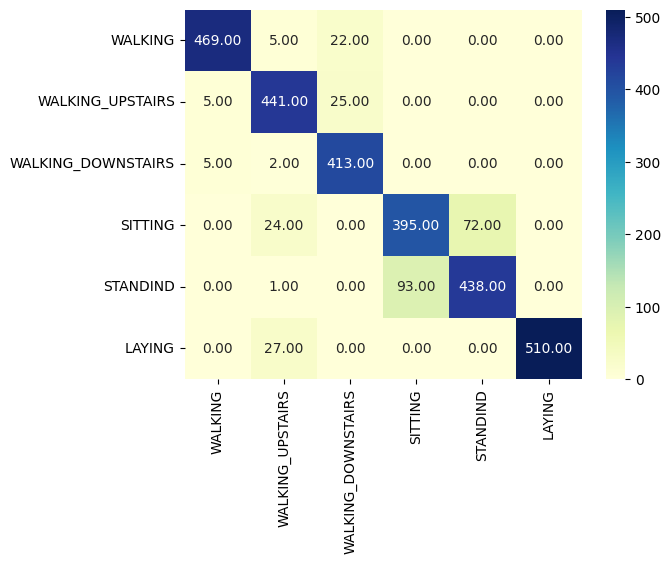

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 -LSTM 2


In [19]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [20]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 7s 24ms/step - loss: 0.8721 - accuracy: 0.6409 - val_loss: 0.4571 - val_accuracy: 0.8132
Epoch 2/10
58/58 [==============================] - 1s 9ms/step - loss: 0.4128 - accuracy: 0.8358 - val_loss: 0.3008 - val_accuracy: 0.8803
Epoch 3/10
58/58 [==============================] - 1s 9ms/step - loss: 0.2622 - accuracy: 0.9011 - val_loss: 0.2347 - val_accuracy: 0.9075
Epoch 4/10
58/58 [==============================] - 1s 9ms/step - loss: 0.1928 - accuracy: 0.9275 - val_loss: 0.1461 - val_accuracy: 0.9402
Epoch 5/10
58/58 [==============================] - 1s 9ms/step - loss: 0.1533 - accuracy: 0.9407 - val_loss: 0.1245 - val_accuracy: 0.9456
Epoch 6/10
58/58 [==============================] - 1s 11ms/step - loss: 0.1373 - accuracy: 0.9431 - val_loss: 0.1190 - val_accuracy: 0.9506
Epoch 7/10
58/58 [==============================] - 1s 9ms/step - loss: 0.1218 - accuracy: 0.9514 - val_loss: 0.1050 - val_accuracy: 0.9587
Epoch 8/10
58/58 [

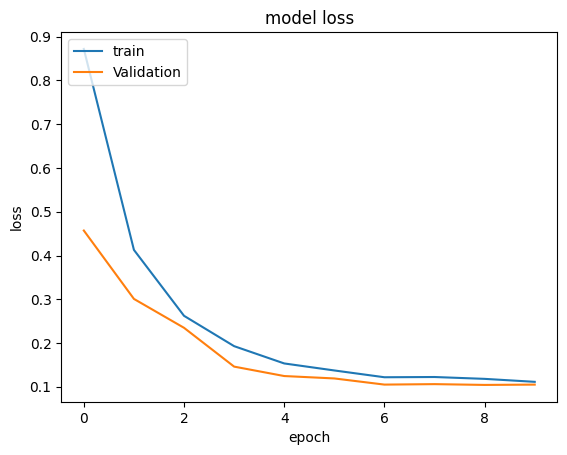

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

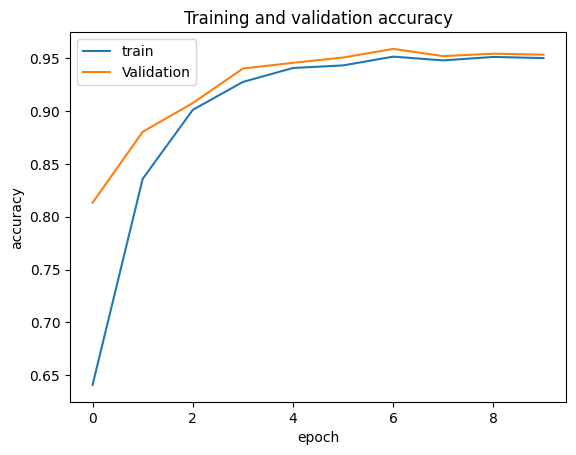

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 4ms/step
[[488   0   8   0   0   0]
 [ 29 416  26   0   0   0]
 [ 11   2 407   0   0   0]
 [  0  24   0 374  93   0]
 [  0   1   0  81 450   0]
 [  0  27   0   0   0 510]]
0.8975229046487954
0.8968595259800396
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       496
           1       0.89      0.88      0.88       471
           2       0.92      0.97      0.95       420
           3       0.82      0.76      0.79       491
           4       0.83      0.85      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

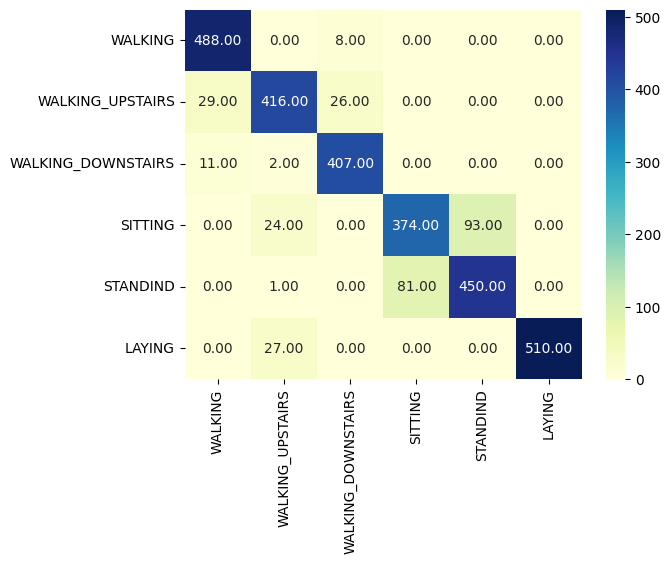

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [24]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 896)        

In [25]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 5s 20ms/step - loss: 0.7873 - accuracy: 0.6711 - val_loss: 0.3971 - val_accuracy: 0.8432
Epoch 2/10
58/58 [==============================] - 0s 8ms/step - loss: 0.3012 - accuracy: 0.8853 - val_loss: 0.1937 - val_accuracy: 0.9393
Epoch 3/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1708 - accuracy: 0.9377 - val_loss: 0.1585 - val_accuracy: 0.9293
Epoch 4/10
58/58 [==============================] - 0s 8ms/step - loss: 0.1429 - accuracy: 0.9444 - val_loss: 0.1300 - val_accuracy: 0.9442
Epoch 5/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.9479 - val_loss: 0.1232 - val_accuracy: 0.9524
Epoch 6/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.9464 - val_loss: 0.1253 - val_accuracy: 0.9474
Epoch 7/10
58/58 [==============================] - 0s 7ms/step - loss: 0.1153 - accuracy: 0.9508 - val_loss: 0.1173 - val_accuracy: 0.9501
Epoch 8/10
58/58 [=

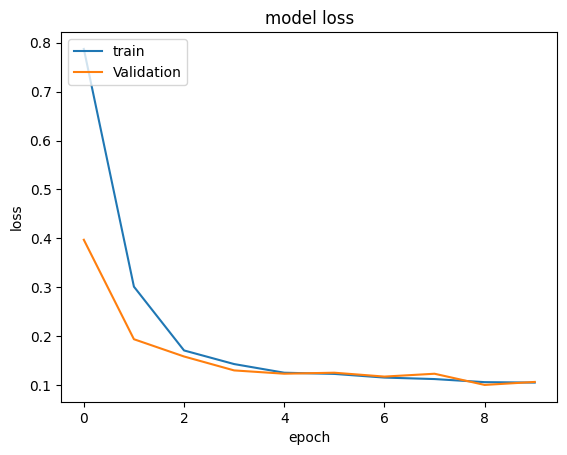

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

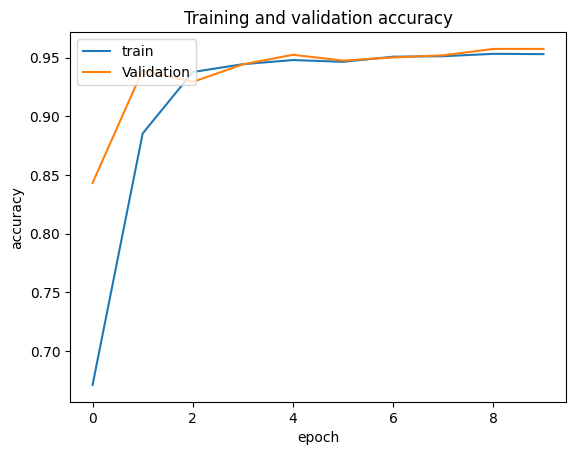

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 3ms/step
[[413  41  42   0   0   0]
 [  0 448  23   0   0   0]
 [  2   4 414   0   0   0]
 [  1  25   0 418  47   0]
 [  0   7   0 108 417   0]
 [  0  27   0   0   0 510]]
0.8890397013912453
0.889318640957562
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       496
           1       0.81      0.95      0.88       471
           2       0.86      0.99      0.92       420
           3       0.79      0.85      0.82       491
           4       0.90      0.78      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

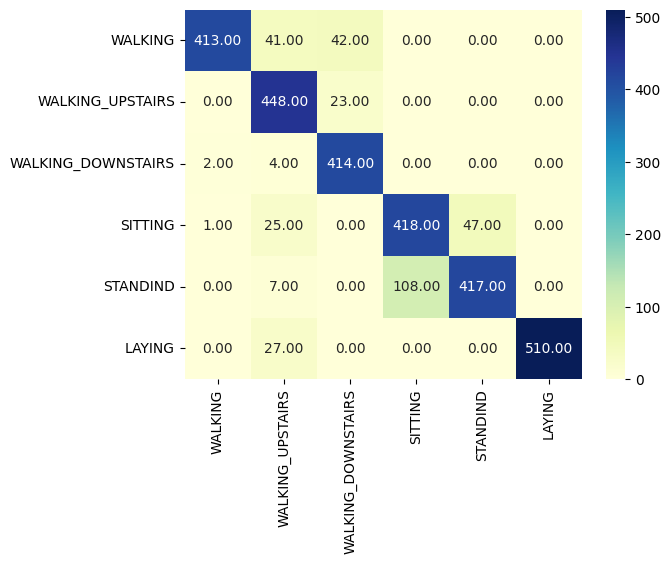

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [29]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 896)        

In [30]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 6s 25ms/step - loss: 0.9165 - accuracy: 0.6145 - val_loss: 0.4836 - val_accuracy: 0.7937
Epoch 2/10
58/58 [==============================] - 1s 10ms/step - loss: 0.3868 - accuracy: 0.8467 - val_loss: 0.2572 - val_accuracy: 0.9044
Epoch 3/10
58/58 [==============================] - 1s 11ms/step - loss: 0.2475 - accuracy: 0.9098 - val_loss: 0.1790 - val_accuracy: 0.9352
Epoch 4/10
58/58 [==============================] - 1s 11ms/step - loss: 0.1742 - accuracy: 0.9331 - val_loss: 0.1479 - val_accuracy: 0.9424
Epoch 5/10
58/58 [==============================] - 1s 13ms/step - loss: 0.1523 - accuracy: 0.9418 - val_loss: 0.1295 - val_accuracy: 0.9501
Epoch 6/10
58/58 [==============================] - 1s 14ms/step - loss: 0.1341 - accuracy: 0.9459 - val_loss: 0.1660 - val_accuracy: 0.9338
Epoch 7/10
58/58 [==============================] - 1s 13ms/step - loss: 0.1228 - accuracy: 0.9502 - val_loss: 0.1079 - val_accuracy: 0.9587
Epoch 8/10
58

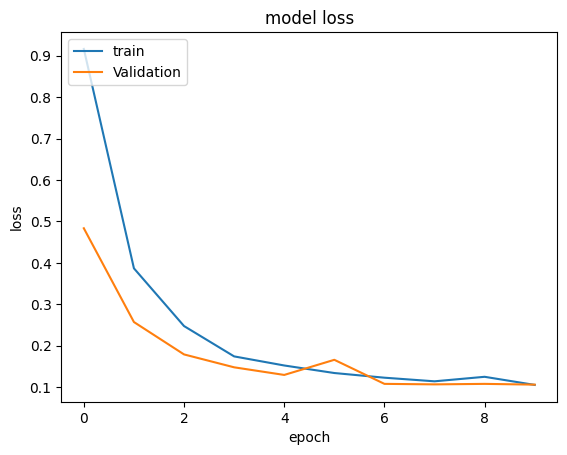

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

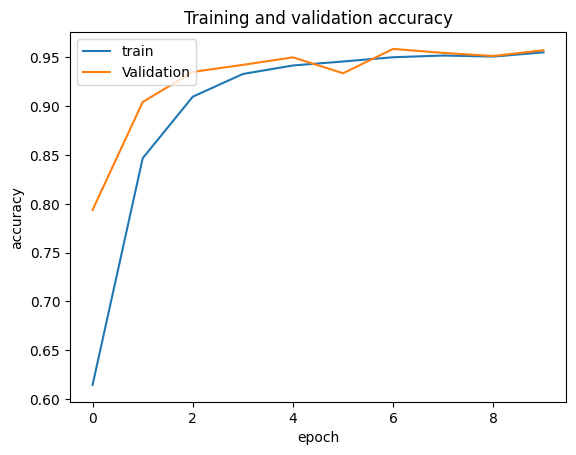

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 3ms/step
[[465   0  31   0   0   0]
 [  5 425  41   0   0   0]
 [ 20   0 400   0   0   0]
 [  2  23   0 385  81   0]
 [  2   1   0  94 435   0]
 [  0  27   0   0   0 510]]
0.8890397013912453
0.8890169835531182
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       496
           1       0.89      0.90      0.90       471
           2       0.85      0.95      0.90       420
           3       0.80      0.78      0.79       491
           4       0.84      0.82      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

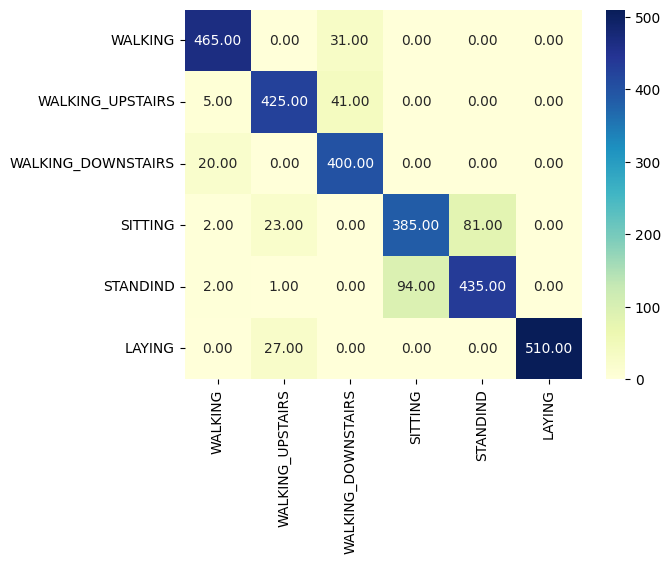

In [33]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')